# Classifying Retinal Images for Diabetes Retinopathy

## Preparations

### Import libraries

In [23]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
from PIL import Image
import os

### Download dataset

#### Download labels

In [2]:
train_df = pd.read_csv("datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv")
test_df = pd.read_csv("datasets/diabetic_retinopathy_images/groundtruths/testing_labels.csv")

train_df.head()


,Image name,Retinopathy grade,Risk of macular edema,Retinopathy
0,IDRiD_001,3,2,1
1,IDRiD_002,3,2,1
2,IDRiD_003,2,2,1
3,IDRiD_004,3,2,1
4,IDRiD_005,4,0,1


In [3]:
train_df.describe()

,Retinopathy grade,Risk of macular edema,Retinopathy
count,413.000000,413.000000,413.000000
mean,1.719128,1.043584,0.675545
std,1.387723,0.949215,0.468739
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000
75%,3.000000,2.000000,1.000000
max,4.000000,2.000000,1.000000


In [4]:
print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

Training shape: (413, 4)
Testing shape: (103, 4)


We aim to binary classification task in this project, so we inspect the column Retinopathy.

In [5]:
print("Training Distribution:", train_df['Retinopathy'].value_counts(1), "\n")
print("Testing Distribution:", test_df['Retinopathy'].value_counts(1))

Training Distribution: Retinopathy
1    0.675545
0    0.324455
Name: proportion, dtype: float64 

Testing Distribution: Retinopathy
1    0.669903
0    0.330097
Name: proportion, dtype: float64


#### Create custom dataset class

In [6]:
class DRDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        # Extract image name (assuming first column contains image names)
        img_name = self.labels_df.iloc[idx, 0]
        
        # Construct full image path
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        # Get binary label from "Retinopathy" column
        label = self.labels_df.iloc[idx, -1]
        label = torch.tensor(label, dtype=torch.float)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

## Data preparation

### Data transform

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

In [8]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

### Initialize train dataloader

In [9]:
TRAIN_IMAGES_DIR = 'datasets/diabetic_retinopathy_images/images/training_images'
TRAIN_LABELS_DIR = 'datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv'

train_dataset = DRDataset(
        img_dir=TRAIN_IMAGES_DIR,
        csv_file=TRAIN_LABELS_DIR,
        transform=train_transform
    )

In [10]:
train_dataloader = DataLoader(train_dataset, 
                             batch_size=16, 
                             shuffle=True)

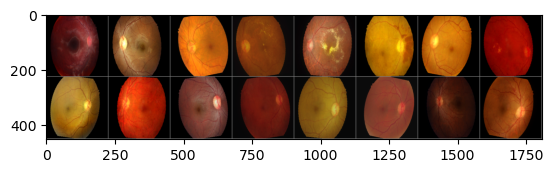

  0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0   0.0   1.0


In [11]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
batch_size = 16

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

### Initialize test dataloader

In [12]:
TEST_IMAGES_DIR = 'datasets/diabetic_retinopathy_images/images/testing_images'
TEST_LABELS_DIR = 'datasets/diabetic_retinopathy_images/groundtruths/testing_labels.csv'

test_dataset = DRDataset(
        img_dir=TEST_IMAGES_DIR,
        csv_file=TEST_LABELS_DIR,
        transform=test_transform
    )

In [13]:
test_dataloader = DataLoader(test_dataset, 
                             batch_size=32, 
                             shuffle=True)

## Image Classification Model - Convolutional Neural Network (CNN)

### Build the Neural Network Architecture

In [16]:
torch.manual_seed(42)

class BinaryClassifierCNN(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Conv Layer 1: Input 3 channels (RGB), output 16 channels
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112
            
            # Conv Layer 2: Input 16, output 32
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56
            
            # Conv Layer 3: Input 32, output 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 56x56 -> 28x28
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),  # Adjust based on input image size
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularization to prevent overfitting
            nn.Linear(128, 1)  # Output: single logit for binary classification
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        x = torch.sigmoid(x).squeeze(1) # Apply sigmoid and squeeze: [batch_size, 1] -> [batch_size]
        return x

In [17]:
model = BinaryClassifierCNN()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [19]:
weight = torch.tensor([279/134]).to(device)  
criterion = nn.BCELoss(weight=weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

### Training Loop

In [20]:
num_epochs = 10
for epoch in range(num_epochs):
    total_train_loss = 0

    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Calculate average loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # Print training losses
    print(f"Epoch [{epoch+1}/{num_epochs}]: Training Loss: {avg_train_loss:.4f}")

Epoch [1/10]: Training Loss: 1.3285
Epoch [2/10]: Training Loss: 1.2990
Epoch [3/10]: Training Loss: 1.2372
Epoch [4/10]: Training Loss: 1.2168
Epoch [5/10]: Training Loss: 1.2148
Epoch [6/10]: Training Loss: 1.1752
Epoch [7/10]: Training Loss: 1.1012
Epoch [8/10]: Training Loss: 1.0739
Epoch [9/10]: Training Loss: 1.1188
Epoch [10/10]: Training Loss: 1.0814


### Testing Set Evaluation

In [21]:
test_pred_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Get model outputs (already has sigmoid activation)
        outputs = model(images)
        
        # Get predicted labels (threshold at 0.5)
        pred_labels = torch.round(outputs)
        test_pred_labels.extend(pred_labels.cpu().numpy())

# Convert to numpy arrays for easier handling
test_pred_labels = np.array(test_pred_labels)

test_true_labels = []
for _, labels in test_dataloader:
    test_true_labels.extend(labels.numpy())

dr_classes = ['No DR', 'DR']
report = classification_report(y_true=test_true_labels, 
                               y_pred=test_pred_labels,
                               target_names=dr_classes)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       No DR       0.40      0.18      0.24        34
          DR       0.68      0.87      0.76        69

    accuracy                           0.64       103
   macro avg       0.54      0.52      0.50       103
weighted avg       0.59      0.64      0.59       103



### Key Insights

The simple CNN for detecting diabetic retinopathy achieved an overall accuracy of 64%. This means that the model correctly predicted 64% of all images in the testing set, which can be considered modest, but there is certainly room for improvement.

#### Class 0 - No DR

- A precision of 0.40 means that when the CNN predicted a patient did not have DR, it was only correct 40% of the time
- A recall of 0.18 means that the CNN correctly identified only 18% of patients without DR
- An F1-score of 0.24 suggests a poor balance between the precision and recall score for class 0

#### Class 1 - DR

- A precision of 0.68 means that when the CNN predicted a patient with DR, it was correct 68% of the time
- A recall of 0.87 means that the CNN correctly identified 87% of patients with DR
- An F1-score of 0.76 suggests a decent balance between recall and precision for class 1

## Conclusion

In conclusion, in this project, the simple CNN Neural Network model was implemented, trained for task image binary classification. The model gave moderate results, though medical specificity considers the better result for Class 1, because it is worse to miss a disease than to misclassify its existence.<br>
Obviously, there is room for improvement via using vision transformerms which are not covered in this project.